In [8]:
import re
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup

import altair as alt
from matplotlib import pyplot as plt

# notebook renderer for Altair
renderer = "default"
alt.renderers.enable(renderer)

URL = "https://hokiesports.com/sports/football/roster/season/2025-26"
HTML_FILE = "vt-football-roster-2025-26.html"

HEADERS = {
    "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120 Safari/537.36"
}


# Virginia Tech Football Roster (2025–26): HTML Webscrape, Data Clean, and Analysis

This notebook targets the Virginia Tech roster page:

- Scrape roster **cards** from the HokieSports roster page HTML (not a simple `<table>`).
- Build a tidy pandas DataFrame (player name, position, class/year, height, weight, hometown, high school, player URL).
- Clean and transform fields (height → inches, weight classes, BMI).
- Explore quick counts and create a few basic visuals.

> **Tip:** If the site changes its HTML structure, the scraping section may need small selector tweaks. Keeping the parsing logic in a few helper functions makes that painless.


### Extracting the roster cards from the HTML page

In [9]:
# Fetch the roster page HTML and save it locally (so you can re-run parsing without re-downloading)
response = requests.get(URL, headers=HEADERS, timeout=30)
response.raise_for_status()

with open(HTML_FILE, "w", encoding="utf-8") as f:
    f.write(response.text)

response.status_code


200

In [7]:
def _clean_spaces(s: str) -> str:
    """Collapse repeated whitespace and strip."""
    return re.sub(r"\s+", " ", (s or "").strip())

def _parse_height_weight_year(text: str):
    """
    Parse year/class, height, and weight from a blob of card text.

    Returns:
      (year, height_str '6-2', height_inches, weight_lbs)
    """
    t = _clean_spaces(text)

    # year/class (optional)
    year = None
    m_year = re.search(
        r"\b(Graduate|Senior|Junior|Sophomore|Freshman|Redshirt\s+(?:Senior|Junior|Sophomore|Freshman))\b",
        t,
        flags=re.IGNORECASE
    )
    if m_year:
        year = m_year.group(1).title()

    # height supports unicode primes (′ ″) and normal ' / "
    m_h = re.search(r"(\d+)\s*[′']\s*(\d+)\s*[″\"]", t)
    height_str = None
    height_in = np.nan
    if m_h:
        ft = int(m_h.group(1))
        inch = int(m_h.group(2))
        height_str = f"{ft}-{inch}"
        height_in = ft * 12 + inch

    # weight: "195 lbs"
    m_w = re.search(r"(\d+)\s*lbs\b", t, flags=re.IGNORECASE)
    weight = np.nan
    if m_w:
        weight = int(m_w.group(1))

    return year, height_str, height_in, weight

POSITION_OPTIONS = [
    "Offensive Line",
    "Defensive Line",
    "Defensive Back",
    "Wide Receiver",
    "Running Back",
    "Quarterback",
    "Linebacker",
    "Tight End",
    "Kicker",
    "Punter",
    "Long Snapper",
]

def _match_position_prefix(s: str):
    s = _clean_spaces(s)
    for pos in sorted(POSITION_OPTIONS, key=len, reverse=True):
        if s.lower().startswith(pos.lower()):
            return pos, _clean_spaces(s[len(pos):])
    return None, s

def _parse_home_line(text: str):
    """
    Attempt to split a roster card line into:
      Position, City, State, High School

    Many cards look like:
      "Defensive Back Virginia Beach, Va. Green Run"
    """
    t = _clean_spaces(text)
    position, remainder = _match_position_prefix(t)
    remainder = _clean_spaces(remainder)

    city = state = high_school = None

    if "," in remainder:
        city_part, rest = remainder.split(",", 1)
        city = _clean_spaces(city_part)
        rest = _clean_spaces(rest)

        # State like "Va." or "N.J." then the rest is the HS
        m = re.match(r"^(?P<state>(?:[A-Za-z]\.[A-Za-z]\.|[A-Za-z]{2,10}\.))\s*(?P<hs>.*)$", rest)
        if m:
            state = _clean_spaces(m.group("state"))
            high_school = _clean_spaces(m.group("hs")) if m.group("hs") else None
        else:
            parts = rest.split(" ", 1)
            state = _clean_spaces(parts[0]) if parts else None
            high_school = _clean_spaces(parts[1]) if len(parts) > 1 else None

    return position, city, state, high_school


In [6]:
# Read the saved HTML and parse roster cards
text = open(HTML_FILE, "r", encoding="utf-8").read()
soup = BeautifulSoup(text, "html.parser")

# Player links typically include /player/ in the href
player_links = soup.select('a[href*="/sports/football/roster/season/2025-26/player/"]')

seen = set()
rows = []

for a in player_links:
    href = a.get("href")
    if not href or href in seen:
        continue
    seen.add(href)

    card = a.find_parent(["li", "article", "div"])
    if card is None:
        continue

    # A compact text blob for parsing
    card_texts = list(card.stripped_strings)
    blob = _clean_spaces(" ".join(card_texts))

    name = _clean_spaces(a.get_text(strip=True))

    year, height_str, height_in, weight = _parse_height_weight_year(blob)

    # Pick a line with a comma (often the hometown/state line)
    home_candidate = None
    for s in card_texts:
        if "," in s:
            home_candidate = s

    position = city = state = high_school = None
    if home_candidate:
        position, city, state, high_school = _parse_home_line(home_candidate)

    rows.append({
        "Name": name,
        "Position": position,
        "Class": year,
        "Height": height_str,
        "Weight": weight,
        "Height, inches": height_in,
        "City": city,
        "State": state,
        "High School": high_school,
        "Player URL": ("https://hokiesports.com" + href) if href.startswith("/") else href,
        "Raw Card Text": blob,   # keep for debugging; drop when satisfied
    })

data = pd.DataFrame(rows)

# basic type cleanup
data["Weight"] = pd.to_numeric(data["Weight"], errors="coerce")
data["Height, inches"] = pd.to_numeric(data["Height, inches"], errors="coerce")

data.shape


(22, 11)

In [10]:
# Preview
data.head(10)


,Name,Position,Class,Height,Weight,"Height, inches",City,State,High School,Player URL,Raw Card Text
0,,None,None,6-6,280,78,Wayne,N.J.,None,https://hokiesports.com/sports/football/roster...,Marlen Bright Marlen Bright X Opens in a new w...
1,,None,Freshman,6-1,195,73,Richmond,Va.,None,https://hokiesports.com/sports/football/roster...,Davion Brown Davion Brown X Opens in a new win...
2,,None,Freshman,6-2,180,74,Virginia Beach,Va.,None,https://hokiesports.com/sports/football/roster...,Zaevion Cleveland Zaevion Cleveland X Opens in...
3,,None,Freshman,6-6,280,78,Midlothian,Va.,None,https://hokiesports.com/sports/football/roster...,Maddox Cochrane Maddox Cochrane X Opens in a n...
4,,None,Freshman,6-3,320,75,Canton,Mich.,None,https://hokiesports.com/sports/football/roster...,Benjamin Eziuka Benjamin Eziuka X Opens in a n...
5,,None,Freshman,6-1,190,73,Suffolk,Va.,None,https://hokiesports.com/sports/football/roster...,Tyrell Grant Jr. Tyrell Grant Jr. X Opens in a...
6,,None,Freshman,6-3,220,75,Upper Marlboro,Md.,None,https://hokiesports.com/sports/football/roster...,Tyson Harley Tyson Harley X Opens in a new win...
7,,None,Freshman,6-4,220,76,Carlsbad,Calif.,None,https://hokiesports.com/sports/football/roster...,Troy Huhn Troy Huhn X Opens in a new window Tr...
8,,None,Freshman,6-4,225,76,Virginia Beach,Va.,None,https://hokiesports.com/sports/football/roster...,Kamren Johnson Kamren Johnson X Opens in a new...
9,,None,Freshman,6-3,215,75,Bristow,Va.,None,https://hokiesports.com/sports/football/roster...,Mathieu Lamah Mathieu Lamah X Opens in a new w...


## Data Exploration and Cleaning

Below: exploring the data, dealing with nulls, resetting the index, standardizing column names, splitting the hometown line into `City`, `State`, and `High School`, and converting height to inches.


In [11]:
# Drop duplicates by Player URL and reset the index
data = data.drop_duplicates(subset=["Player URL"]).reset_index(drop=True)

# Optional: drop the raw text once you're happy with parsing
# data = data.drop(columns=["Raw Card Text"])

# Missingness overview
data.isna().sum().sort_values(ascending=False)


Position          22
High School       22
Class              1
Name               0
Height             0
Weight             0
Height, inches     0
City               0
State              0
Player URL         0
Raw Card Text      0
dtype: int64

#### Checking for duplicates (Player URL, Name)

In [13]:
# Helper to check whether a column has duplicates
def dups_check(df, col):
    if df[col].nunique(dropna=False) < df.shape[0]:
        print(f"There are duplicate entries in `{col}`")
    else:
        print(f"All values in `{col}` are unique")

dups_check(data, "Player URL")
dups_check(data, "Name")


All values in `Player URL` are unique
There are duplicate entries in `Name`


In [14]:
# Counts of players by class/year and position
class_counts = data.groupby("Class")["Name"].count().sort_values(ascending=False).to_dict()
position_counts = data.groupby("Position")["Name"].count().sort_values(ascending=False).to_dict()

class_counts, position_counts


({'Freshman': 21}, {})

## Data Transformation

Below: classifying weight as `Heavy`, `Average`, and `Light`, plus creating a `BMI` column.


In [15]:
# Weight class function (same idea as the UGA project)
def weight_class(weight):
    if pd.isna(weight):
        return "N/A"
    if weight > 270:
        return "Heavy"
    if weight < 220:
        return "Light"
    if 220 <= weight <= 270:
        return "Average"
    return "N/A"

data["Weight Class"] = data["Weight"].apply(weight_class)

# BMI (only if height + weight exist)
data["BMI"] = np.where(
    (~data["Weight"].isna()) & (~data["Height, inches"].isna()) & (data["Height, inches"] > 0),
    np.round((703 * data["Weight"]) / (data["Height, inches"] ** 2), 2),
    np.nan
)

data[["Name", "Position", "Class", "Height", "Weight", "Height, inches", "Weight Class", "BMI"]].head(10)


,Name,Position,Class,Height,Weight,"Height, inches",Weight Class,BMI
0,,None,None,6-6,280,78,Heavy,32.35
1,,None,Freshman,6-1,195,73,Light,25.72
2,,None,Freshman,6-2,180,74,Light,23.11
3,,None,Freshman,6-6,280,78,Heavy,32.35
4,,None,Freshman,6-3,320,75,Heavy,39.99
5,,None,Freshman,6-1,190,73,Light,25.06
6,,None,Freshman,6-3,220,75,Average,27.50
7,,None,Freshman,6-4,220,76,Average,26.78
8,,None,Freshman,6-4,225,76,Average,27.38
9,,None,Freshman,6-3,215,75,Light,26.87


In [16]:
# BMI categories (same thresholds as the UGA notebook)
categories = {"Overweight": 0, "Normal": 0, "Underweight": 0}

for v in data["BMI"].dropna():
    if v >= 25:
        categories["Overweight"] += 1
    elif v >= 18.5:
        categories["Normal"] += 1
    else:
        categories["Underweight"] += 1

categories


{'Overweight': 20, 'Normal': 2, 'Underweight': 0}

In [17]:
# Group players that share a last name (same idea as UGA notebook)
names = {}
for nm in data["Name"].dropna():
    parts = nm.split()
    if len(parts) < 2:
        continue
    ln = parts[-1]
    names.setdefault(ln, []).append(nm)

same_last_names = [tuple(v) for v in names.values() if len(v) > 1]
same_last_names = sorted(same_last_names, key=lambda x: (-len(x), x[0].split()[-1]))
same_last_names[:15]


[]

## Data Visualization

Here, I show quick trends and insights from the dataset. I also exclude players missing height or weight for the height/weight/BMI plots.


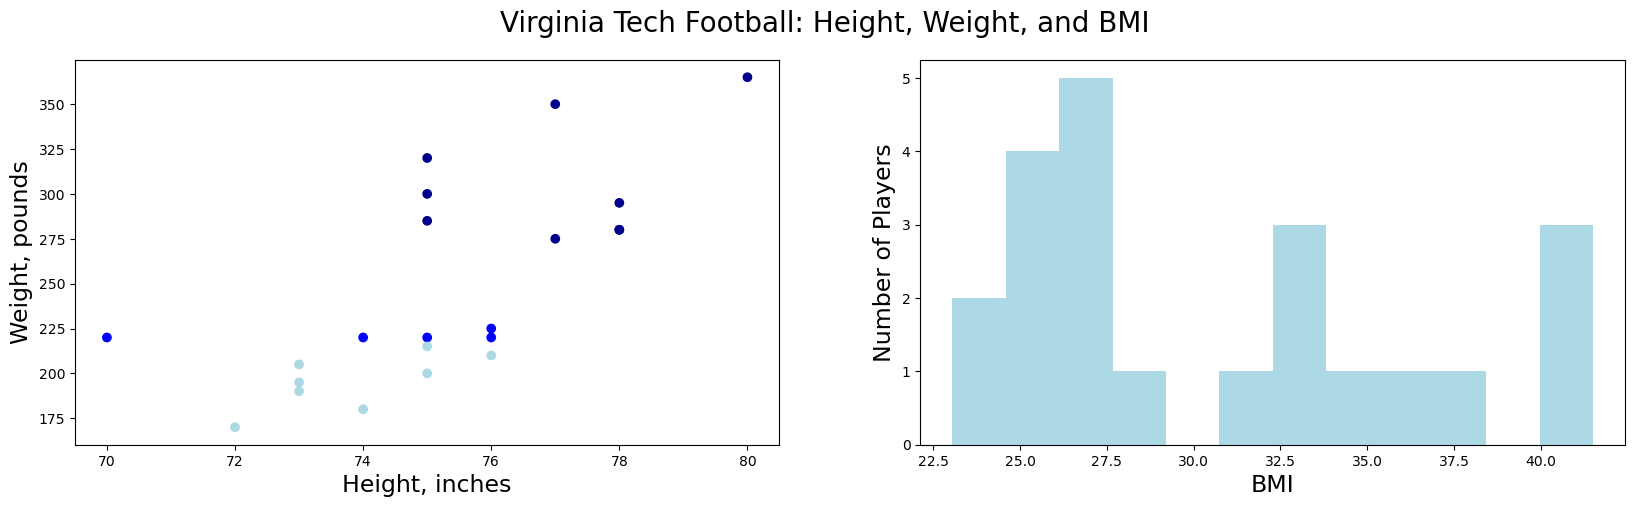

In [18]:
# Exclude missing height/weight for plots
data2 = data[(data["Weight Class"] != "N/A") & (~data["Weight"].isna()) & (~data["Height, inches"].isna())].copy()

fig, ax = plt.subplots(1, 2, figsize=(20, 5), sharey=False)

colors = {"Heavy": "darkblue", "Average": "blue", "Light": "lightblue"}

ax[0].scatter(data2["Height, inches"], data2["Weight"], c=data2["Weight Class"].map(colors))
ax[1].hist(data2["BMI"].dropna(), bins=12, color="lightblue")

fig.suptitle("Virginia Tech Football: Height, Weight, and BMI", fontsize=20)
ax[0].set_ylabel("Weight, pounds", fontsize=17)
ax[0].set_xlabel("Height, inches", fontsize=17)
ax[1].set_xlabel("BMI", fontsize=17)
ax[1].set_ylabel("Number of Players", fontsize=17)
plt.show()


# NOTE: Some visuals may not render depending on your notebook environment. If needed, save figures as images.

In [19]:
# Heat map showing height/weight density (Altair)
alt.Chart(data2).mark_rect().encode(
    alt.X("Height, inches:Q", bin=alt.Bin(maxbins=15)),
    alt.Y("Weight:Q", bin=alt.Bin(maxbins=15)),
    alt.Color("count():Q", scale=alt.Scale(scheme="blues")),
).configure_rect(binSpacing=1)


C:\Users\jomck\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
C:\Users\jomck\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
C:\Users\jomck\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
C:\Users\jomck\anaconda3\Lib\site-packages\altair\utils\core.

alt.Chart(...)

In [ ]:
# Height and Weight distributions side by side (Altair)
height_hist = alt.Chart(data2).mark_bar().encode(
    alt.X("Height, inches:Q", bin=alt.Bin(maxbins=15)),
    y="count()"
)

weight_hist = alt.Chart(data2).mark_bar().encode(
    alt.X("Weight:Q", bin=alt.Bin(maxbins=15)),
    y="count()"
)

height_hist | weight_hist


In [ ]:
# Number of players by State (Altair)
alt.Chart(data.dropna(subset=["State"])).mark_bar().encode(
    alt.X("State:N", sort=alt.EncodingSortField(field="State", op="count", order="descending")),
    alt.Y("count():Q"),
)


In [ ]:
# Exploratory: weight class distribution (matplotlib)
plt.hist(data2["Weight Class"])
plt.ylabel("Number of Players", fontsize=17)
plt.xlabel("Weight Class", fontsize=17)
plt.title("Number of Players by Weight Class, Virginia Tech Football")
plt.show()

# Exploratory: height by weight class
plt.scatter(data2["Weight Class"], data2["Height, inches"])
plt.ylabel("Height, inches", fontsize=17)
plt.xlabel("Weight Class", fontsize=17)
plt.title("Player Heights (in inches) by Weight Class, Virginia Tech Football")
plt.show()
